# Data Forecasting

The module is in charge of: 
- forecasting the value of temperature in the next X seconds; 
- forecasting the value of humidity in the next X seconds; 
- forecasting the value of the gas sensor in the next X seconds 

(X is defined by users or developers). 

The time-series of the predicted values must be saved on INFLUX and shown on the GRAFANA dashboard as well; e.g. by using two lines for the temperature graph, one related to raw measurements, one to predictions. One or multiple techniques for time-series forecasting can be developed and compared.


## Import Dependencies

In [2]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

# Data retrival from influx

In [ ]:
!pip3 install influxdb_client

In [ ]:
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
token = '0-boCREZ1XTzYhmT3RYogxFDtraRzOEZsMYNxjp0mBOWHCif47lUv2UddrAfyJUwupk33ci92-aHHFWhjv2pRg=='
bucket = 'temperature'
org = 'iot_group'
client = InfluxDBClient(url="http://192.168.43.177:8086", token=token, org=org)
query_api = client.query_api()
write_api = client.write_api(write_options=SYNCHRONOUS)

In [ ]:
query = 'from(bucket: "temperature")' \
  '|> range(start:2022-08-10T15:00:00Z, stop:2022-09-20T15:00:00Z)'

In [ ]:
result = client.query_api().query(org=org, query=query)

-Exploiting the query results in order to obtain a dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Implementation Temperature Predictor

In [ ]:
dataset_path = "/content/drive/MyDrive/Datasets/Forecasting/temp.csv"
df = pd.read_csv(dataset_path)
df.head()

In [ ]:
df.head()

In [ ]:
#evolution over time of our data
plot_cols = ['y']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)



In [ ]:
df.describe().transpose()

In [ ]:
nrows = (len(df.values))
splitPoint = int (nrows * 0.60)
train = df['y'] [:splitPoint]
test = df ['y'] [splitPoint:]

In [ ]:
 # Check whether the time-series is stationary through the Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
train_new = train.diff().dropna()
result = adfuller(train_new)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

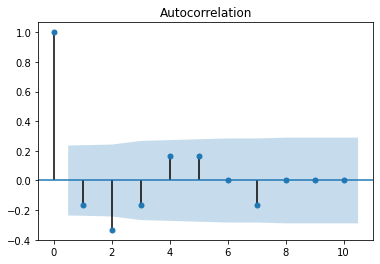

In [ ]:
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(train_new, lags=10)
plt.show()

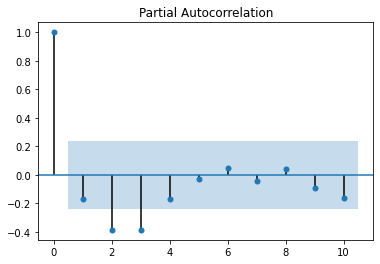

In [ ]:
fig = tsaplots.plot_pacf(train_new, lags=10)
plt.show()

In [ ]:
#Step 6; Apply ARIMA model
from statsmodels.tsa.arima_model import ARIMA
history = [x for x in train]
predictions = list()
print(test)
for t in test.index:
  model = ARIMA(history, order=(0,0,1))
  model_fit = model. fit()
  output = model_fit.forecast()
  yest = output[0]
  predictions.append(yest)
  obs= test[t]
  history.append(obs)
  print ('predicted=%f, expected=%f' % (yest, obs))

Test RMSE: 0.019


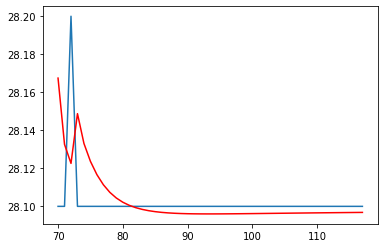

In [ ]:
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f'% rmse)

df2 = pd. DataFrame (predictions)
df2. set_index(test.index, inplace=True)
plt.plot(test)
plt.plot(df2, color='red')
plt.show()

## Implementation Humidity Predictor

In [ ]:
dataset_path = "/content/drive/MyDrive/Datasets/Forecasting/hum.csv"
df = pd.read_csv(dataset_path)
df.head()

,409151bfa0cc,409151bfa0cc.1
0,2022-06-05 23:03:12,49.9
1,2022-06-05 23:03:15,49.9
2,2022-06-05 23:03:17,49.9
3,2022-06-05 23:03:20,49.8
4,2022-06-05 23:03:22,49.8


In [ ]:
df = df.rename(columns={"409151bfa0cc" : 'time', "409151bfa0cc.1" : 'y'})
df.head()

,time,y
0,2022-06-05 23:03:12,49.9
1,2022-06-05 23:03:15,49.9
2,2022-06-05 23:03:17,49.9
3,2022-06-05 23:03:20,49.8
4,2022-06-05 23:03:22,49.8


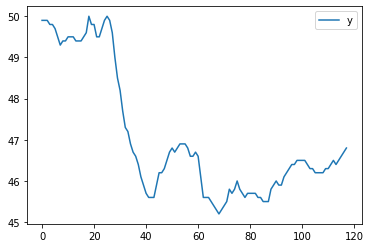

In [ ]:
#evolution over time of our data
plot_cols = ['y']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True)

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
y,118.0,47.049153,1.572344,45.2,45.825,46.45,48.425,50.0


In [ ]:
nrows = (len(df.values))
splitPoint = int (nrows * 0.60)
train = df['y'] [:splitPoint]
test = df ['y'] [splitPoint:]

In [ ]:
 # Check whether the time-series is stationary through the Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.015842
p-value: 0.747443


In [ ]:
train_new = train.diff().dropna()
result = adfuller(train_new)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.107289
p-value: 0.000942


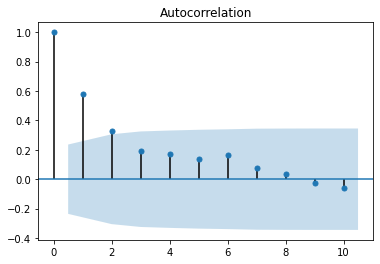

In [ ]:
fig = tsaplots.plot_acf(train_new, lags=10)
plt.show()

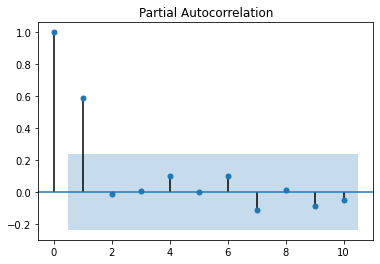

In [ ]:
fig = tsaplots.plot_pacf(train_new, lags=10)
plt.show()

In [ ]:
history = [x for x in train]
predictions = list()
print(test)
for t in test.index:
  model = ARIMA(history, order=(1,1,1))
  model_fit = model.fit()
  output = model_fit.forecast()
  yest = output[0]
  predictions.append(yest)
  obs= test[t]
  history.append(obs)
  print ('predicted=%f, expected=%f' % (yest, obs))

Test RMSE: 0.118


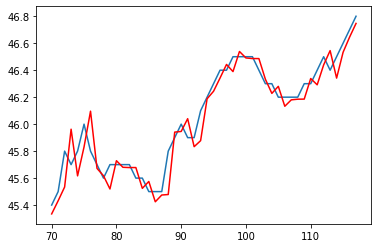

In [ ]:
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f'% rmse)

df2 = pd.DataFrame(predictions)
df2. set_index(test.index, inplace=True)
plt.plot(test)
plt.plot(df2, color='red')
plt.show()

In [4]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

In [5]:
dataset_path = "/content/dataset1.csv"
df = pd.read_csv(dataset_path)
df.head()

,result,table,_start,_stop,_time,_value,_field,_measurement,clientId,lat,lng,prediction
0,NaN,0,2022-08-10T15:00:00Z,2022-09-20T15:00:00Z,2022-08-25T10:13:02.3585624Z,29.4,temperature,val,diubi-esp-32,42.84629,13.904817,no
1,NaN,0,2022-08-10T15:00:00Z,2022-09-20T15:00:00Z,2022-08-25T10:13:04.8724766Z,29.4,temperature,val,diubi-esp-32,42.84629,13.904817,no
2,NaN,0,2022-08-10T15:00:00Z,2022-09-20T15:00:00Z,2022-08-25T10:13:07.3884615Z,29.4,temperature,val,diubi-esp-32,42.84629,13.904817,no
3,NaN,0,2022-08-10T15:00:00Z,2022-09-20T15:00:00Z,2022-08-25T10:13:09.8994101Z,29.4,temperature,val,diubi-esp-32,42.84629,13.904817,no
4,NaN,0,2022-08-10T15:00:00Z,2022-09-20T15:00:00Z,2022-08-25T10:13:12.414701Z,29.5,temperature,val,diubi-esp-32,42.84629,13.904817,no


In [ ]:
plot_cols = ['_value']
plot_features = df[plot_cols]
plot_features.index = df['_time']
print(df.to_string())
_ = plot_features.plot(subplots=True)

In [7]:
nrows = (len(df.values))
splitPoint = int (nrows * 0.60)
train = df['_value'] [:splitPoint]
test = df ['_value'] [splitPoint:]

In [8]:
!pip install pystan==2.19.1.1 --quiet
!pip install fbprophet --quiet
!pip install yfinance --quiet

In [9]:
import pandas as pd
import yfinance as yf
from datetime import datetime,timezone
import dateutil.parser
import time
from datetime import timedelta
import plotly.graph_objects as go
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import warnings

warnings.filterwarnings('ignore')

pd.options.display.float_format = '${:,.2f}'.format

In [10]:
arr = []
for t in df['_time'].values:
      d=dateutil.parser.parse(t)
      arr=d.strftime('%Y-%m-%d')
      df['_time'].replace({ t:arr },inplace=True)

data = df.reset_index()[['_time','_value']]
data.columns=['ds','y']

In [12]:
m = Prophet(
    daily_seasonality = False, 
    weekly_seasonality = False, 
    yearly_seasonality = True, 
    seasonality_mode = "multiplicative", 
    growth = "linear"
)

m.fit(data)

In [13]:
future = m.make_future_dataframe(periods = 365)
future.tail()

,ds
363,2023-08-22
364,2023-08-23
365,2023-08-24
366,2023-08-25
367,2023-08-26


In [15]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
363,2023-08-22,$232.70,$-335.80,$781.13
364,2023-08-23,$233.00,$-337.19,$783.17
365,2023-08-24,$233.30,$-339.19,$785.16
366,2023-08-25,$233.59,$-342.70,$786.81
367,2023-08-26,$233.90,$-344.07,$789.87


In [16]:
plot_plotly(m, forecast)

## Implement Gas Predictor

In [ ]:
dataset_path = "/content/drive/MyDrive/Datasets/Forecasting/gas.csv"
df = pd.read_csv(dataset_path)

In [ ]:
df.head()

,Time,y
0,2022-06-05 21:07:11,4095
1,2022-06-05 21:07:13,4095
2,2022-06-05 21:07:16,4095
3,2022-06-05 21:07:18,4095
4,2022-06-05 21:07:21,4095


In [ ]:
df['y'].size

4288

In [ ]:
df['y'][0:4288] = 4095

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


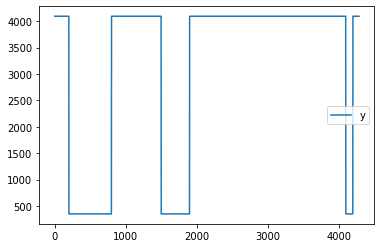

In [ ]:
#evolution over time of our data
plot_cols = ['y']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True)

In [ ]:
df['y'][3000:4000] = [4095 for i in range(0,1000)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
y,4288.0,3134.295709,1635.698257,350.0,350.0,4095.0,4095.0,4095.0


In [ ]:
nrows = (len(df.values))
splitPoint = int (nrows * 0.50)
train = df['y'] [:splitPoint]
test = df ['y'] [splitPoint:]

Check for stationarity 

In [ ]:
 # Check whether the time-series is stationary through the Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.005413
p-value: 0.284205


In [ ]:
train_new = train.diff().dropna()
result = adfuller(train_new)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -46.260134
p-value: 0.000000


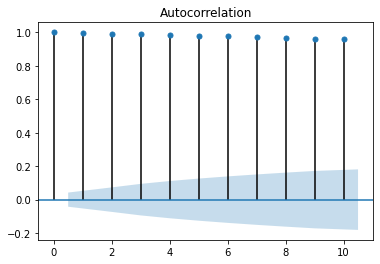

In [ ]:
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(train, lags=10)
plt.show()

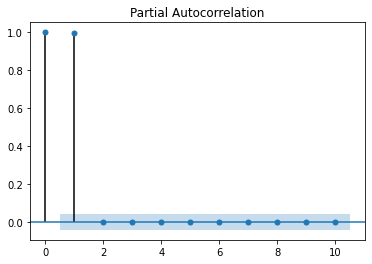

In [ ]:
fig = tsaplots.plot_pacf(train, lags=10)
plt.show()

In [ ]:
# Apply ARIMA model
from statsmodels.tsa.arima_model import ARIMA
history = list(np.array([x for x in train_new]).astype('float64'))
predictions = list()
print(test)
for t in test.index:
  model = ARIMA(history, order=(1,1,1))
  model_fit = model.fit()
  output = model_fit.forecast()
  yest = output[0]
  predictions.append(yest)
  obs= test[t]
  history.append(obs)
  print ('predicted=%f, expected=%f' % (yest, obs))

Test RMSE: 180.939


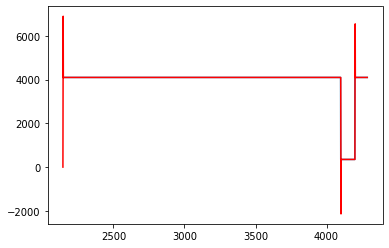

In [ ]:
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f'% rmse)

df2 = pd. DataFrame (predictions)
df2. set_index(test.index, inplace=True)
plt.plot(test)
plt.plot(df2, color='red')
plt.show()

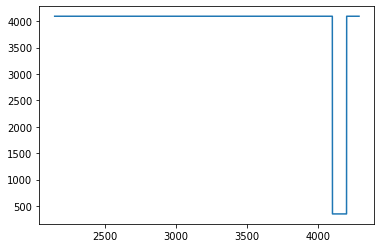

In [ ]:
plt.plot(test)


In [ ]:
import pickle
pickle.dump(model_fit, open('gas-model', 'wb'))